# Advanced feature selection with Python

This notebooks shows how you can use DataRobot's Python client to accomplish feature selection by creating aggregated Feature Impact using models created during Autopilot. For more information about the allowed feature transformations, reference the [Python client documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest/autodoc/api_reference.html#datarobot.models.Project.create_type_transform_feature).


## 要件

- Python version 3.7.3.

- DataRobot API version 2.14.0.

- A DataRobot <code>Project</code> object.

- A DataRobot <code>Model </code> object.


Small adjustments may be needed depending on the Python version and DataRobot API version you are using.


## ライブラリのインポート

In [1]:
import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("ticks")
sns.set_context("poster")

### DataRobotに接続する

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).


In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

## Select models

For this workflow, select the top five performing models from the project.


In [ ]:
project = dr.Project.get(project_id="<project-id>")
models = project.get_models()
models = models[:5]
print(models)

## Create a dataframe

Create a dataframe of features' relative rank for the top five models.


In [4]:
all_impact = pd.DataFrame()
for model in models[0:5]:
    # This can take about one minute for each model
    feature_impact = model.get_or_request_feature_impact(max_wait=600)

    # Ready to be converted to dataframe
    df = pd.DataFrame(feature_impact)
    # Track model names and IDs for auditing purposes
    df["model_type"] = model.model_type
    df["model_id"] = model.id
    # By sorting and re-indexing, the new index becomes the 'ranking'
    df = df.sort_values(by="impactUnnormalized", ascending=False)
    df = df.reset_index(drop=True)
    df["rank"] = df.index.values

    # Add to the master list of all models' feature ranks
    all_impact = pd.concat([all_impact, df], ignore_index=True)

In [5]:
all_impact.head()

featureName  impactNormalized  impactUnnormalized  \
0          number_inpatient          1.000000            0.031445   
1  discharge_disposition_id          0.950723            0.029896   
2         medical_specialty          0.828289            0.026046   
3          number_diagnoses          0.609419            0.019163   
4        num_lab_procedures          0.543238            0.017082   

  redundantWith                                         model_type  \
0          None  eXtreme Gradient Boosted Trees Classifier with...   
1          None  eXtreme Gradient Boosted Trees Classifier with...   
2          None  eXtreme Gradient Boosted Trees Classifier with...   
3          None  eXtreme Gradient Boosted Trees Classifier with...   
4          None  eXtreme Gradient Boosted Trees Classifier with...   

                   model_id  rank  
0  5e620be2d7c7a80c003d16a2     0  
1  5e620be2d7c7a80c003d16a2     1  
2  5e620be2d7c7a80c003d16a2     2  
3  5e620be2d7c7a80c003d16a2     3  
4  5e620be2d7c7a80c003d16a2     4

## View rankings and distribution

You can find the N features with the highest median ranking and visualize the distributions:


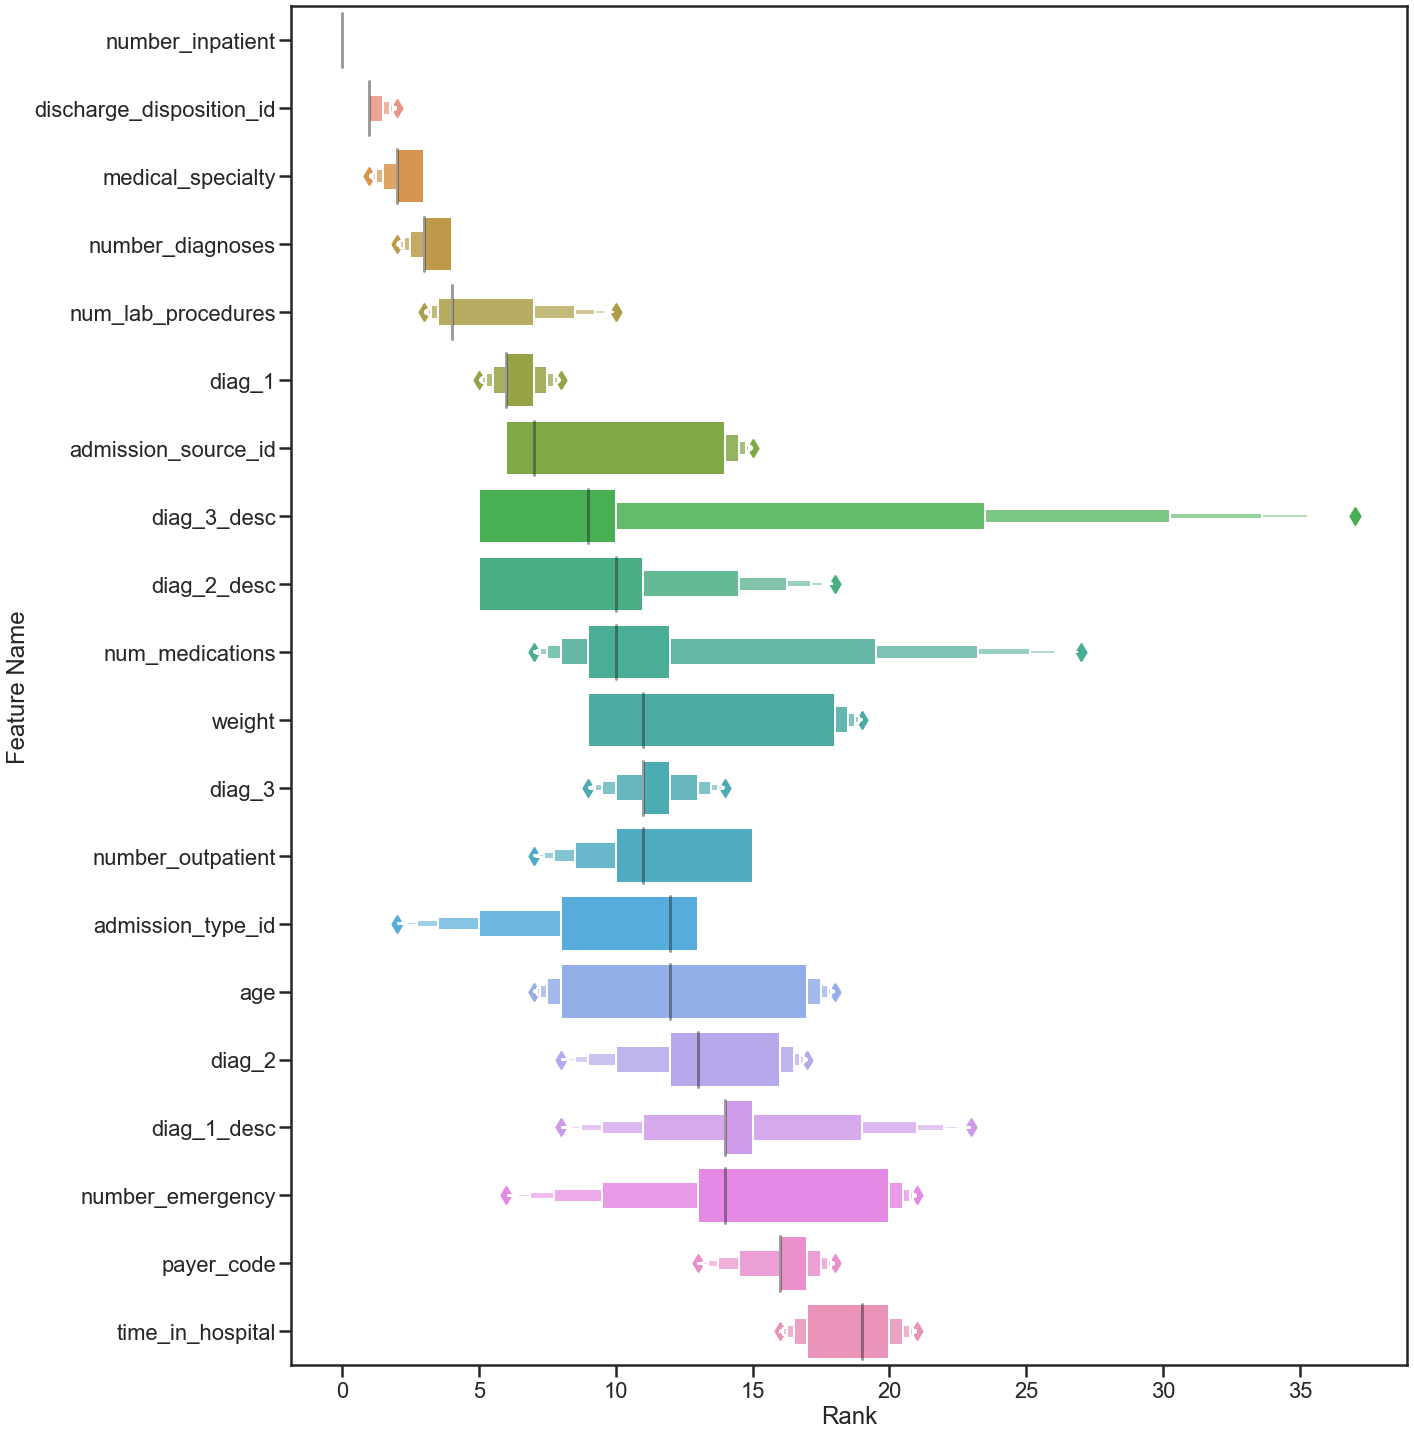

In [9]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel("ERROR")

n_feats = 20
top_feats = list(
    all_impact.groupby("featureName").median().sort_values("rank").head(n_feats).index.values
)

top_feat_impact = all_impact.query("featureName in @top_feats").copy()

fig, ax = plt.subplots(figsize=(20, 25))
sns.boxenplot(y="featureName", x="rank", data=top_feat_impact, order=top_feats, ax=ax, orient="h")
plt.title("Features with highest Feature Impact rating")
_ = ax.set_ylabel("Feature Name")
_ = ax.set_xlabel("Rank")

## 新しい特徴量セットの作成

After analysis, you can create a new feature list with the top features and rerun Autopilot. Note that a feature list can also be created for a dataset and becomes usable across all projects that use that dataset in the future.


In [ ]:
# Create new featurelist and run autopilot
featurelist = project.create_featurelist("consensus-top-features", list(top_feats))
featurelist_id = featurelist.id

project.start_autopilot(featurelist_id=featurelist_id)
project.wait_for_autopilot()